In [26]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import scipy as sp
from better_profanity import profanity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
!pip install better_profanity
!pip install vaderSentiment

## Load data

In [2]:
source_flist = glob("../data/dataset/source_tweets/*.csv")
df_source = []
for fname in source_flist:
    df_source += [pd.read_csv(fname, dtype=str)]
df_source = pd.concat(df_source)
for col in ['retweet_count', 'quote_count', 'like_count', 'reply_count']:
    df_source[col] = pd.to_numeric(df_source[col], errors='coerce')
df_source.reset_index(drop=True, inplace=True)
len(df_source)

42573

In [3]:
df_source.head()

,tweet_id,text,author_id,conversation_id,reply_settings,created_at,in_reply_to_user_id,lang,retweet_count,reply_count,like_count,quote_count,possibly_sensitive,reference_type,referenced_tweet_id,hashtags
0,1293312474473693184,How could @chrisbharrison not ask the first ki...,26737428,1293312474473693184,everyone,2020-08-11T22:24:57.000Z,NaN,en,0.0,0.0,0.0,0.0,False,NaN,NaN,TheBachelorGOAT
1,1291516028304928768,I can’t watch big brother anymore cause my fir...,1234701687119634434,1291516028304928768,everyone,2020-08-06T23:26:31.000Z,NaN,en,0.0,0.0,1.0,0.0,False,NaN,NaN,BB22
2,1290259091667816448,First panic attack of the day &amp; it’s not e...,4062908727,1290259091667816448,everyone,2020-08-03T12:11:53.000Z,NaN,en,1.0,3.0,21.0,0.0,False,NaN,NaN,SAPro
3,1289991519357698048,Had my first panic attack at @SamsClub today ...,752698184661475329,1289991519357698048,everyone,2020-08-02T18:28:39.000Z,NaN,en,0.0,2.0,1.0,0.0,False,NaN,NaN,panicattacks Anxiety stick manual driving sams...
4,1289324147286433793,Yesterday I had my first panic attack in a yea...,479122895,1289324147286433793,everyone,2020-07-31T22:16:45.000Z,NaN,en,0.0,1.0,3.0,0.0,False,NaN,NaN,panicdisorder panicattack pots dysautonomia


In [4]:
reply_flist = glob("../data/dataset/reply_chains/*.csv")
df_replies = []
for fname in reply_flist:
    df_replies += [pd.read_csv(fname, dtype=str)]
df_replies = pd.concat(df_replies)
for col in ['retweet_count', 'quote_count', 'like_count', 'reply_count']:
    df_replies[col] = pd.to_numeric(df_replies[col], errors='coerce')
df_replies['referenced_tweet_id'] = df_replies['referenced_tweet_id'].astype(object)
df_replies.reset_index(drop=True, inplace=True)
len(df_replies)

51414

In [5]:
df_replies.head()

,tweet_id,text,author_id,conversation_id,reply_settings,created_at,in_reply_to_user_id,lang,retweet_count,reply_count,like_count,quote_count,possibly_sensitive,reference_type,referenced_tweet_id,hashtags
0,1511151436196950027,@HeelsYes Me too,29469036,1511149853505691650,everyone,2022-04-05T01:19:12.000Z,248799990,en,0.0,0.0,0.0,0.0,False,replied_to,1511149853505691650,NaN
1,1511151288238682122,@jademloren https://t.co/vzwFg66eeZ,2953835985,1511148244491026440,everyone,2022-04-05T01:18:37.000Z,554414656,und,0.0,0.0,0.0,0.0,False,replied_to,1511148244491026440,NaN
2,1511122256335888394,@lindzjonas93 Welcome to the club. Accepting h...,559062040,1511113579449266177,everyone,2022-04-04T23:23:15.000Z,18530946,en,0.0,0.0,1.0,0.0,False,replied_to,1511113579449266177,NaN
3,1511153172953317385,"@MullberryZone Uhhhhhh, yes pls",1268387232257376256,1511108428655218694,everyone,2022-04-05T01:26:06.000Z,1231092739493842944,en,0.0,0.0,0.0,0.0,False,replied_to,1511108428655218694,NaN
4,1511113028309245952,"@MullberryZone Let's do it, NOW",741358912314560512,1511108428655218694,everyone,2022-04-04T22:46:35.000Z,1231092739493842944,en,0.0,0.0,1.0,0.0,False,replied_to,1511108428655218694,NaN


## Derive tweet features for analysis

In [6]:
df_source['Date_time'] = df_source['created_at'].astype('datetime64[ns]')
print(df_source.Date_time.max(), df_source.Date_time.min())

2022-04-05 04:10:27 2009-04-15 20:18:56


In [7]:
df_source['created_at'] = pd.to_datetime(df_source['created_at'], infer_datetime_format=True) 
df_source['created_at_month'] = df_source['created_at'].dt.month
df_source['created_at_day'] = df_source['created_at'].dt.day
df_source['created_at_year'] = df_source['created_at'].dt.year
df_source['created_at_hour'] = df_source['created_at'].dt.hour
df_source['created_at_hour'].fillna(df_source['created_at_hour'].median(), inplace=True)
#print(max(df_source['created_at_month']), min(df_source['created_at_month']))
#print(max(df_source['created_at_day']), min(df_source['created_at_day']))
#print(max(df_source['created_at_year']), min(df_source['created_at_year']))
#print(max(df_source['created_at_hour']), min(df_source['created_at_hour']))
#df_source.drop("created_at", axis=1, inplace=True)

In [8]:
# Derive the VADER scores for the tweets

sia = SentimentIntensityAnalyzer()

positive_sentiment = []
negative_sentiment = []
overall_sentiment = []

text = df_source.text
for tweet in tqdm(text):
    results = sia.polarity_scores(tweet)
    positive_sentiment.append(results['pos'])
    negative_sentiment.append(results['neg'])
    overall_sentiment.append(results['compound'])

df_source['tweet_positivity'] = positive_sentiment
df_source['tweet_negativity'] = negative_sentiment
df_source['tweet_overall_sentiment'] = overall_sentiment

100%|███████████████████████████████████| 42573/42573 [00:13<00:00, 3073.10it/s]


In [10]:
# Convert hashtags to number of hashtags
hashtags = df_source.hashtags
contains_hashtag = []
for h in hashtags:
    if pd.isna(h):
        contains_hashtag.append(0)
    else:
        contains_hashtag.append(1)
print(sum(contains_hashtag))  # number of tweets with hashtags
df_source['contains_hashtag'] = contains_hashtag
#df_source.drop("hashtags", axis=1, inplace=True)

17164


In [11]:
# Derive mentions
mentions = []
tweets = df_source.text
for tweet in tweets:
    if "@" in tweet:
        mentions.append(1)
    else:
        mentions.append(0)
df_source['mentions'] = mentions
print(sum(mentions))

1672


In [12]:
# Derive capitals
capitals = []
tweets = df_source.text
for tweet in tweets:
    alph = list(filter(str.isalpha, tweet)) 
    if len(alph) > 0:
        capitals.append(sum(map(str.isupper, alph)) / len(alph))
    else:
        capitals.append(0)
df_source['capitals'] = capitals

In [19]:
swear_words = []  # % words that are swear words
uses_profanity = []  # 0 = no profanity present. 1 = profanity present.

tweets = df_source.text
for tweet in tqdm(tweets):
    words = tweet.split()
    swear_count = 0
    contains_swear = False
    for word in words:
        if profanity.contains_profanity(word):
            swear_count += 1
            contains_swear = True
    if len(words) > 0:
        swear_words.append(swear_count/len(words))
    else:
        swear_words.append(0)
    if contains_swear:
        uses_profanity.append(1)
    else:
        uses_profanity.append(0)
df_source['swear_words'] = swear_words
df_source['uses_profanity'] = uses_profanity
#print(swear_words[10], swear_words[25], swear_words[28])
#print(uses_profanity[10], uses_profanity[25], uses_profanity[28])

100%|█████████████████████████████████████| 42569/42569 [07:32<00:00, 94.17it/s]

0.0 0.0 0.0
0 0 0


In [22]:
# Derive contains question
contains_question = []
tweets = df_source.text
for tweet in tweets:
    if "?" in tweet:
        contains_question.append(1)
    else:
        contains_question.append(0)
df_source['contains_question'] = contains_question
print(contains_question[:5])

In [23]:
# Derive number of words
num_words = []
tweets = df_source.text
for tweet in tweets:
    num_words.append(len(tweet.split()))
df_source['number_of_words'] = num_words
print(num_words[:5])

[27, 44, 14, 49, 27]


In [24]:
# Derive time of day
time_of_day = []
hours = df_source.created_at_hour
for hour in hours:
    time_of_day.append(hour/24)
df_source['time_of_day'] = time_of_day
print(time_of_day[:5])

[0.9166666666666666, 0.9583333333333334, 0.5, 0.75, 0.9166666666666666]


In [25]:
# Derive first person
first_person = []

fp_words = ["i", "me", "my", "we", "us", "mine", "our", "myself", "ourselves"]

tweets = df_source.text
for tweet in tweets:
    words = tweet.split()
    flag = True
    for word in words:
        word = word.lower()
        clean_word = ''.join(filter(str.isalpha, word))
        if word in fp_words:
            first_person.append(1)
            flag = False
            break
    if flag:
        first_person.append(0)
df_source['first_person'] = first_person

## Analysis 1: tweet features vs engagement received

In [9]:
# Derive the interaction scores for the tweets
df_source = df_source[df_source['like_count'].notna()]
df_source = df_source[df_source['retweet_count'].notna()]
df_source = df_source[df_source['reply_count'].notna()]
df_source = df_source[df_source['quote_count'].notna()]
index_names = df_source[df_source['quote_count'] == "False" ].index
df_source.drop(index_names, inplace = True)

likes = df_source['like_count'].tolist()
retweets = df_source['retweet_count'].tolist()
replies = df_source['reply_count'].tolist()
quotes = df_source['quote_count'].tolist()
quotes = list(map(int, quotes))
quotes = [float(i) for i in quotes]

interaction_score = []
for i in range(len(likes)):
    interaction_score.append(quotes[i]*10 + replies[i]*5 + retweets[i]*3 + likes[i])
    
df_source['interaction_score'] = interaction_score
df_source['quote_count'] = quotes

print(df_source['interaction_score'].mean())

12.866780990861894


In [41]:
model_data = df_source[['tweet_positivity','tweet_negativity','contains_hashtag','capitals','mentions','swear_words','uses_profanity','contains_question','number_of_words','time_of_day','first_person']]
#model_data = df_source[['tweet_positivity','tweet_negativity','mentions','swear_words']]
#model_data = df_source[['tweet_positivity','mentions','swear_words']]
model_labels = df_source.interaction_score
print(len(model_data), len(model_labels))

42569 42569


In [42]:
X_train, X_test, y_train, y_test = train_test_split(model_data, model_labels, test_size=.2)#, stratify=model_labels)
print(len(X_train), len(X_test))

34055 8514


In [44]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [45]:
predictions = model.predict(X_test)

In [46]:
print(metrics.mean_absolute_error(y_test, predictions))
print(metrics.mean_squared_error(y_test, predictions))
print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

17.054830882979466
10068.828669367673
100.34355320282252


In [47]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,predictions)
print(r2)

-0.001604968517464389


In [48]:
print("RMSE",np.log(np.sqrt(metrics.mean_squared_error(y_test,predictions))))

RMSE 4.608599830057818


Feature: 0, Score: 11.60914
Feature: 1, Score: 11.26526
Feature: 2, Score: -2.13360
Feature: 3, Score: 3.65532
Feature: 4, Score: 18.12000
Feature: 5, Score: -79.85832
Feature: 6, Score: 8.23365
Feature: 7, Score: -3.01561
Feature: 8, Score: 0.76258
Feature: 9, Score: 4.51096
Feature: 10, Score: -5.20378
 
 
 


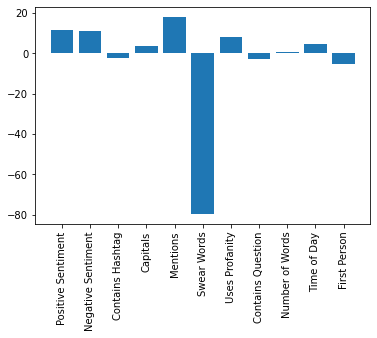

In [49]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance


print(" ")
print(" ")
print(" ")
bars = ['Positive Sentiment', 'Negative Sentiment', 'Contains Hashtag', 'Capitals', 'Mentions', 'Swear Words', 'Uses Profanity', 'Contains Question', 'Number of Words', 'Time of Day', 'First Person']
#plt.title("Feature Importance")
plt.bar(bars, importance)
plt.xticks(rotation=90)
plt.show()

## Analysis 2: tweet features vs reply sentiment

In [27]:
sentiment_df = df_source.copy()

In [29]:
# Derive reply VADER sentiment

conversations = sentiment_df.conversation_id
response_sentiment = []
count = 1
for con in tqdm(conversations):
    count += 1

    temp_df = df_replies.copy()

    index_names = temp_df[ temp_df['conversation_id'] != con ].index
    temp_df.drop(index_names, inplace=True)

    temp_tweets = temp_df.text
    sentiment_sum = 0
    for tweet in temp_tweets:
        results = sia.polarity_scores(tweet)
        sentiment_sum += results['compound']

    if len(temp_tweets) == 0:
        response_sentiment.append(np.nan)
    else:
        response_sentiment.append(sentiment_sum/len(temp_tweets))
    del temp_df

sentiment_df['response_sentiment'] = response_sentiment
index_names = sentiment_df[ sentiment_df['response_sentiment'] == np.nan].index
sentiment_df.drop(index_names, inplace=True)

100%|█████████████████████████████████████| 42569/42569 [36:46<00:00, 19.30it/s]


In [30]:
# Derive label
responses = sentiment_df.response_sentiment
reaction = []
for response in responses:
    if response >= .25:
        reaction.append(1)  # positive label
    elif response <= -.25:
        reaction.append(0)  # negative label
    else:
        reaction.append(2)  # invalid label (to be removed)

sentiment_df['reaction'] = reaction
index_names = sentiment_df[ sentiment_df['reaction'] > 1 ].index
sentiment_df.drop(index_names, inplace=True)
print(sentiment_df['reaction'].value_counts())

1    4974
0    1482
Name: reaction, dtype: int64


In [31]:
# Normalize word counts
word_count = sentiment_df.number_of_words
normalize_word_count = []
min_count = min(word_count)
max_count = max(word_count)

for count in word_count:
    normalize_word_count.append((count - min_count)/(max_count - min_count))

sentiment_df['number_of_words'] = normalize_word_count

In [32]:
reply_model_data = sentiment_df[['tweet_positivity','tweet_negativity','contains_hashtag','capitals','mentions','swear_words','uses_profanity','contains_question','number_of_words','time_of_day','first_person']]
#reply_model_data = sentiment_df[['tweet_positivity','tweet_negativity','contains_hashtag','capitals','mentions','contains_question']]
reply_model_labels = sentiment_df.reaction#df.interaction_score
print(len(reply_model_data), len(reply_model_labels))

6456 6456


In [33]:
X_train_reply, X_test_reply, y_train_reply, y_test_reply = train_test_split(reply_model_data, reply_model_labels, test_size=.1, stratify=reply_model_labels)
print(len(X_train_reply), len(X_test_reply))

5810 646


In [34]:
from sklearn.svm import LinearSVC
reply_model = LinearSVC(C=.55, class_weight="balanced")
reply_model.fit(X_train_reply, y_train_reply)

LinearSVC(C=0.55, class_weight='balanced')

In [35]:
predictions = reply_model.predict(X_test_reply)
# compute statistics

accuracy = accuracy_score(y_test_reply, predictions)
print("Accuracy: ", accuracy)

precision1 = precision_score(y_test_reply, predictions)
print("Precision: ", precision1)

recall1 = recall_score(y_test_reply, predictions)
print("Recall: ", recall1)

f1_score1 = f1_score(y_test_reply,  predictions)
print("F1_Score: ", f1_score1)

specificity1 = recall_score(y_test_reply, predictions, pos_label=0)
print("Specificity: ", specificity1)

fpr1, tpr1, threshold1 = roc_curve(y_test_reply, predictions)
auc1 = auc(fpr1, tpr1)
print("AUC: ", auc1)

Accuracy:  0.5479876160990712
Precision:  0.821875
Recall:  0.5281124497991968
F1_Score:  0.6430317848410758
Specificity:  0.6148648648648649
AUC:  0.5714886573320308


[ 1.32624354 -0.1986621   0.18152189 -0.08506851  0.04923685 -0.27437803
 -0.17149145 -0.10825983  0.05484507  0.08580191  0.01699016]
Feature: 0, Score: 1.32624
Feature: 1, Score: -0.19866
Feature: 2, Score: 0.18152
Feature: 3, Score: -0.08507
Feature: 4, Score: 0.04924
Feature: 5, Score: -0.27438
Feature: 6, Score: -0.17149
Feature: 7, Score: -0.10826
Feature: 8, Score: 0.05485
Feature: 9, Score: 0.08580
Feature: 10, Score: 0.01699
 
 
 


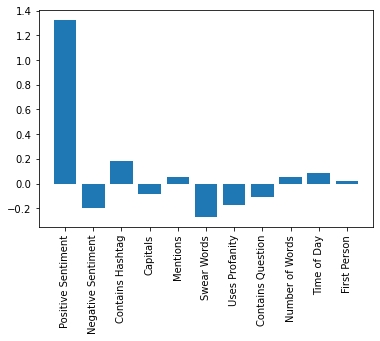

In [37]:
importance = reply_model.coef_[0]
print(importance)
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
print(" ")
print(" ")
print(" ")
bars = ['Positive Sentiment', 'Negative Sentiment', 'Contains Hashtag', 'Capitals', 'Mentions', 'Swear Words', 'Uses Profanity', 'Contains Question', 'Number of Words', 'Time of Day', 'First Person']
#pyplot.title("Feature Importance")
plt.bar(bars, importance)
plt.xticks(rotation=90)
plt.show()